In [19]:
# ----------------------------
# CELL 1: imports / setup
# ----------------------------
import sys
import os

project_root = os.path.abspath("..")
sys.path.append(project_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from config import *
from Data.raw_data_loader import load_raw_crypto_csv
from Models.zscore import zscore_signal
from Models.ou import ou_signal              # FIXED (was ou_signal_on_spread)
from Models.trend import trend_signal
from Models.mining import mining_signal
from Backtest.engine import run_backtest
from Backtest.metrics import build_summary_table, rolling_sharpe

plt.style.use("default")

In [20]:
# ----------------------------
# CELL 2: load / clean data
# ----------------------------
df = load_raw_crypto_csv(DATA_PATH, start_date=DATA_START_DATE)   # FIXED (added start_date)

df = df[(df["BTC-USD_close"] > 0)].copy()

btc_ret = df["BTC-USD_close"].pct_change()
df = df[btc_ret.abs() < 1.0]   # remove extreme data errors

print("Shape:", df.shape)
print("Start:", df.index.min(), "End:", df.index.max())

Shape: (3019, 12)
Start: 2017-11-02 00:00:00 End: 2026-02-09 00:00:00


In [21]:
# ----------------------------
# CELL 3: base model positions (FIXED to match your Models/* signatures)
# ----------------------------
import config as cfg

# Z-score model (expects df)
z_pos = zscore_signal(
    df,
    price_column=cfg.PRICE_COLUMN_BTC,
    resid_window=cfg.ZSCORE_WINDOW,
    entry_z=cfg.ZSCORE_ENTRY_Z,
    exit_z=cfg.ZSCORE_EXIT_Z,
    long_short=cfg.ZSCORE_LONG_SHORT,
    filter_fast=cfg.TREND_FAST_WINDOW,
    filter_slow=cfg.TREND_SLOW_WINDOW,
    use_vol_target=cfg.USE_VOL_TARGET,
    vol_target=cfg.VOL_TARGET,
    vol_window=cfg.VOL_WINDOW,
    max_leverage=cfg.LEVERAGE_CAP,
).shift(1).fillna(0.0)

# OU model (expects Series)
ou_pos = ou_signal(
    df[cfg.PRICE_COLUMN_BTC],
    window=cfg.OU_WINDOW,
    entry_z=cfg.OU_ENTRY_Z,
    exit_z=cfg.OU_EXIT_Z,
    long_short=cfg.OU_LONG_SHORT,
).shift(1).fillna(0.0)

# Trend model (expects df)
trend_pos = trend_signal(
    df,
    price_column=cfg.PRICE_COLUMN_BTC,
    fast_window=cfg.TREND_FAST_WINDOW,
    slow_window=cfg.TREND_SLOW_WINDOW,
    long_only=cfg.TREND_LONG_ONLY,
    leverage_aggressive=cfg.TREND_AGGRESSIVE,
    leverage_neutral=cfg.TREND_NEUTRAL,
    leverage_defensive=cfg.TREND_DEFENSIVE,
).shift(1).fillna(0.0)

# Mining model (expects df; NO long_short arg)
mining_pos = mining_signal(
    df,
    z_window=cfg.MINING_Z_WINDOW,
    entry_z=cfg.MINING_ENTRY_Z,
    exit_z=cfg.MINING_EXIT_Z,
    use_log_edge=cfg.MINING_USE_LOG_EDGE,
).shift(1).fillna(0.0)

print("Mean abs positions:",
      "z", float(z_pos.abs().mean()),
      "ou", float(ou_pos.abs().mean()),
      "trend", float(trend_pos.abs().mean()),
      "mining", float(mining_pos.abs().mean()))

Mean abs positions: z 0.9844319311030142 ou 0.9506459092414706 trend 1.0221265319642265 mining 0.33487909903941704


In [22]:
# ----------------------------
# CELL 4: stochastic tactical + combos
# ----------------------------
btc_buy_hold_pos = pd.Series(1.0, index=df.index, dtype=float)

def clip_pos(pos: pd.Series) -> pd.Series:
    return pos.clip(-LEVERAGE_CAP, LEVERAGE_CAP)

# BTC stochastic-style tactical model
def btc_stochastic_tactical_signal(df: pd.DataFrame) -> pd.Series:
    price = df["BTC-USD_close"].astype(float)
    cost = df["COST_TO_MINE"].replace(0.0, np.nan).astype(float)

    valuation_ratio = price / cost
    log_price = np.log(price.replace(0.0, np.nan))
    ou_z = (log_price - log_price.rolling(90).mean()) / log_price.rolling(90).std()

    ma_200 = price.rolling(200).mean()
    regime_trend = (price > ma_200).astype(float)

    signal = pd.Series(0.0, index=df.index, dtype=float)
    signal.loc[valuation_ratio < 1.05] = 1.0
    signal.loc[(regime_trend == 0.0) & (ou_z < -1.5)] = 1.0
    signal.loc[(regime_trend == 1.0) & (ou_z > -0.5)] = 1.0
    signal.loc[(ou_z > 2.0) & (valuation_ratio > 2.0)] = 0.0

    return signal.shift(1).fillna(0.0)

stochastic_pos = btc_stochastic_tactical_signal(df)

# combos
z_ou_pos = clip_pos(0.00 * z_pos + 0.40 * ou_pos + 0.60 * stochastic_pos)
ou_trend_pos = clip_pos(0.20 * ou_pos + 0.40 * trend_pos + 0.75 * stochastic_pos)
all_models_pos = clip_pos(0.60 * z_pos + 0.00 * ou_pos + 0.00 * trend_pos + 0.80 * stochastic_pos)

In [23]:
# ----------------------------
# CELL 5: run backtests
# ----------------------------
buy_hold_results = run_backtest(
    price_series=df["BTC-USD_close"],
    position=btc_buy_hold_pos,
    fee_bps=FEE_BPS,
    slippage_bps=SLIPPAGE_BPS,
    leverage_cap=LEVERAGE_CAP,
)

stochastic_results = run_backtest(
    price_series=df["BTC-USD_close"],
    position=stochastic_pos,
    fee_bps=FEE_BPS,
    slippage_bps=SLIPPAGE_BPS,
    leverage_cap=LEVERAGE_CAP,
)

z_ou_results = run_backtest(
    price_series=df["BTC-USD_close"],
    position=z_ou_pos,
    fee_bps=FEE_BPS,
    slippage_bps=SLIPPAGE_BPS,
    leverage_cap=LEVERAGE_CAP,
)

ou_trend_results = run_backtest(
    price_series=df["BTC-USD_close"],
    position=ou_trend_pos,
    fee_bps=FEE_BPS,
    slippage_bps=SLIPPAGE_BPS,
    leverage_cap=LEVERAGE_CAP,
)

all_models_results = run_backtest(
    price_series=df["BTC-USD_close"],
    position=all_models_pos,
    fee_bps=FEE_BPS,
    slippage_bps=SLIPPAGE_BPS,
    leverage_cap=LEVERAGE_CAP,
)

In [24]:
# ----------------------------
# CELL 6: summary table  (FIXED brackets)
# ----------------------------
summary = build_summary_table({
    "BTC Buy & Hold": {
        "returns": buy_hold_results["net_returns"],
        "position": btc_buy_hold_pos,
    },
    "Stochastic Tactical": {
        "returns": stochastic_results["net_returns"],
        "position": stochastic_pos,
    },
    "Z-Score + OU": {
        "returns": z_ou_results["net_returns"],
        "position": z_ou_pos,
    },
    "OU + Trend": {
        "returns": ou_trend_results["net_returns"],
        "position": ou_trend_pos,
    },
    "Grand Combo (All Models)": {
        "returns": all_models_results["net_returns"],
        "position": all_models_pos,
    },
})

summary

,Sharpe,Sortino,CAGR,MaxDD,Calmar,AnnualReturn,AnnualVol,Observations,AnnualTurnover
Strategy,,,,,,,,,
BTC Buy & Hold,0.753704,1.020556,0.320936,-0.833990,0.384820,0.502618,0.666864,3019,0.000000
Stochastic Tactical,1.161993,1.406231,0.624292,-0.542021,1.151784,0.637798,0.548883,3019,16.563432
Z-Score + OU,1.021916,1.340843,0.511053,-0.640032,0.798480,0.570879,0.558636,3019,9.986419
OU + Trend,1.030092,1.373626,0.632431,-0.760722,0.831357,0.803453,0.779982,3019,13.118963
Grand Combo (All Models),1.168752,1.423510,0.689150,-0.669493,1.029361,0.723824,0.619314,3019,17.433919


In [25]:
# ----------------------------
# CELL 6.5: run base backtests and create *_results dicts
# (must run before the equity plot cell)
# ----------------------------
import config as cfg

def run_backtest_from_position(price: pd.Series, pos: pd.Series, fee_bps: float, slippage_bps: float) -> dict:
    """
    Minimal backtest to produce the keys your plot cell expects:
      - net_equity
      - net_ret
    Uses: net_ret = pos.shift(0) * price.pct_change() - costs
    Costs: (fee+slippage) applied on turnover |Δpos|.
    """
    price = price.astype(float)
    ret = price.pct_change().fillna(0.0)

    pos = pos.reindex(price.index).fillna(0.0)

    # turnover costs
    turn = pos.diff().abs().fillna(0.0)
    cost = (fee_bps + slippage_bps) / 1e4 * turn

    net_ret = (pos * ret) - cost
    net_equity = (1.0 + net_ret).cumprod()

    return {
        "net_ret": net_ret,
        "net_equity": net_equity,
        "turnover": turn,
    }

# price
price_btc = df[cfg.PRICE_COLUMN_BTC].astype(float)

# buy & hold
buy_hold_pos = pd.Series(1.0, index=price_btc.index)
buy_hold_results = run_backtest_from_position(price_btc, buy_hold_pos, fee_bps=0.0, slippage_bps=0.0)

# base models (positions should already exist from your "CELL 3")
z_results = run_backtest_from_position(price_btc, z_pos, cfg.FEE_BPS, cfg.SLIPPAGE_BPS)
ou_results = run_backtest_from_position(price_btc, ou_pos, cfg.FEE_BPS, cfg.SLIPPAGE_BPS)
trend_results = run_backtest_from_position(price_btc, trend_pos, cfg.FEE_BPS, cfg.SLIPPAGE_BPS)
mining_results = run_backtest_from_position(price_btc, mining_pos, cfg.FEE_BPS, cfg.SLIPPAGE_BPS)

print("Built results:", [k for k in ["z_results","ou_results","trend_results","mining_results","buy_hold_results"] if k in globals()])

Built results: ['z_results', 'ou_results', 'trend_results', 'mining_results', 'buy_hold_results']


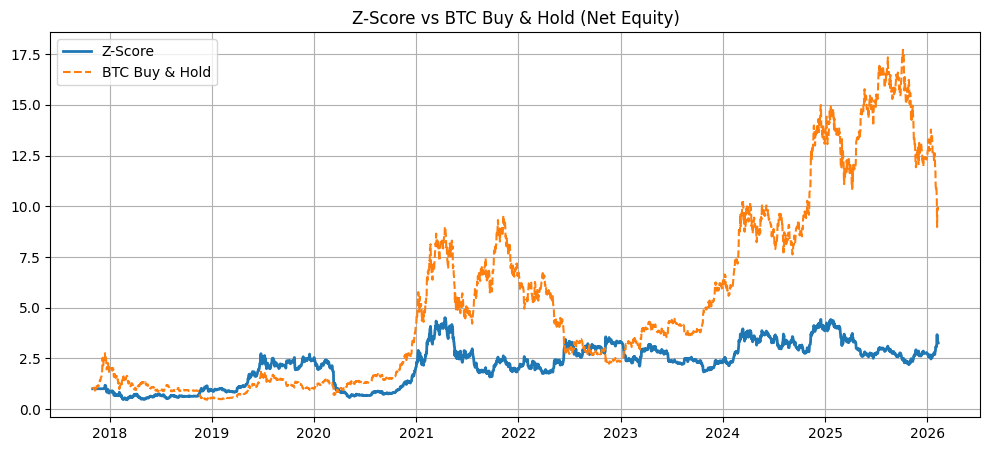

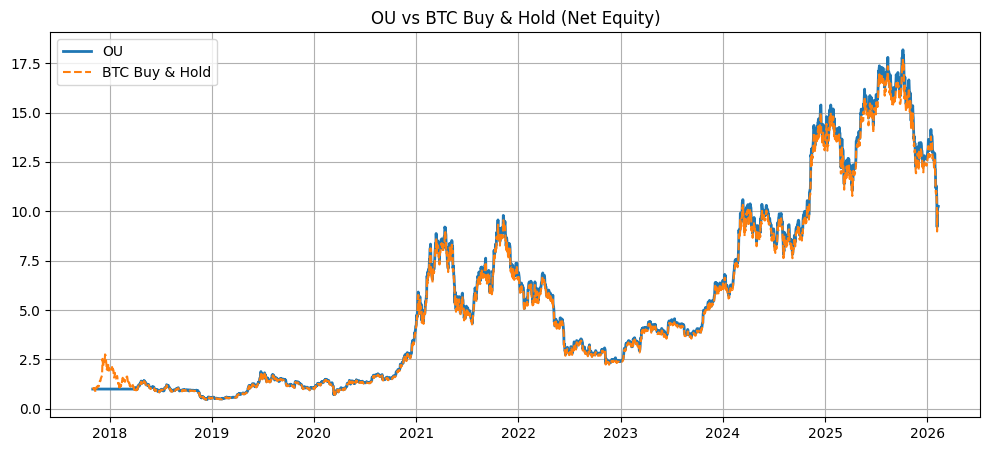

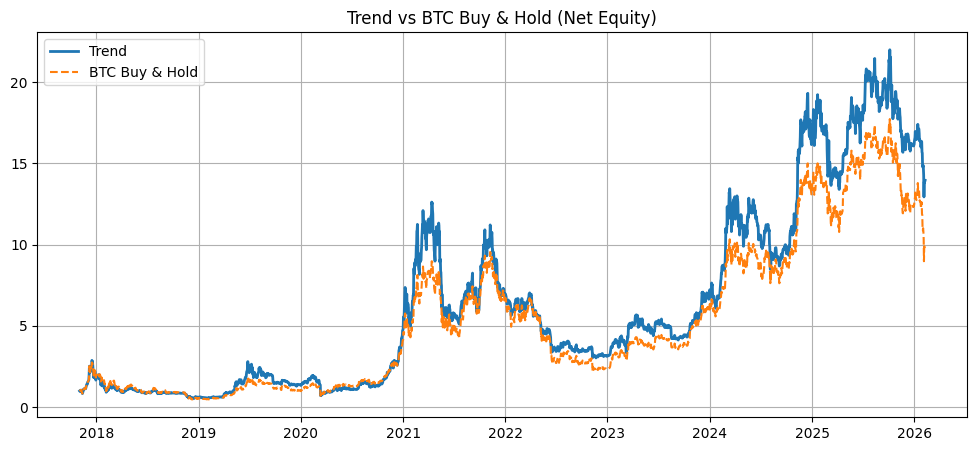

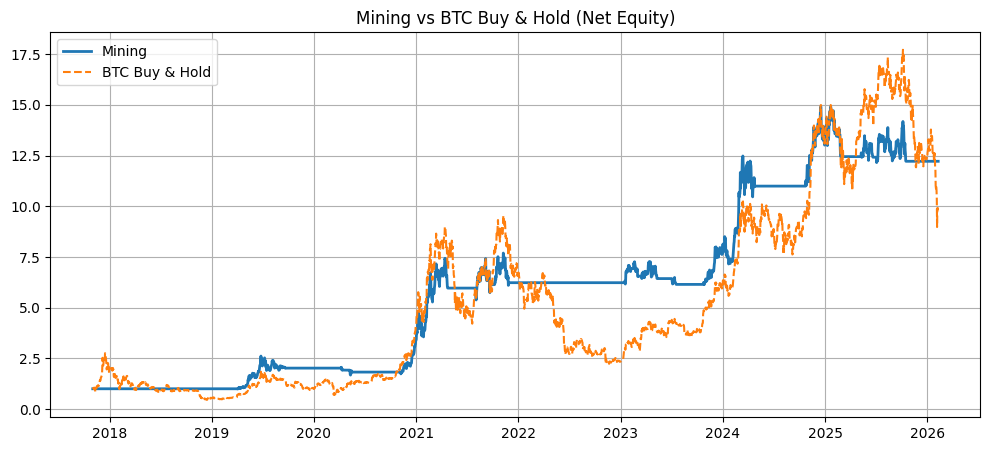

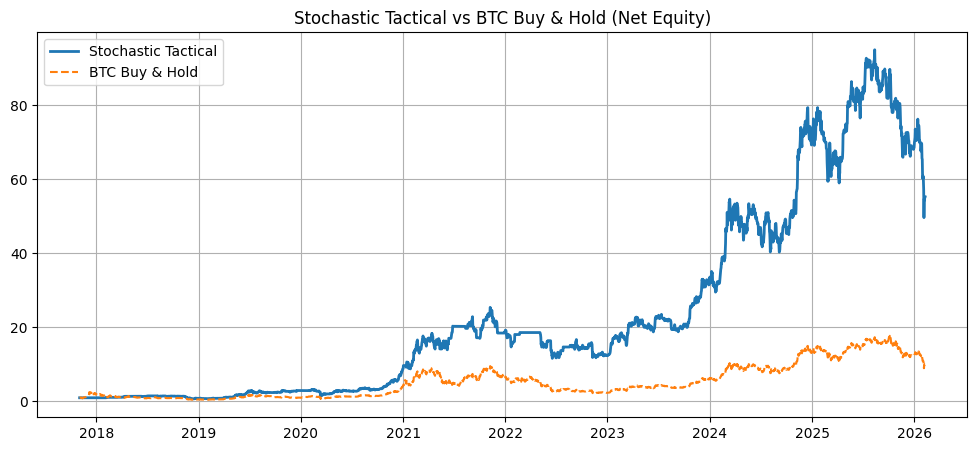

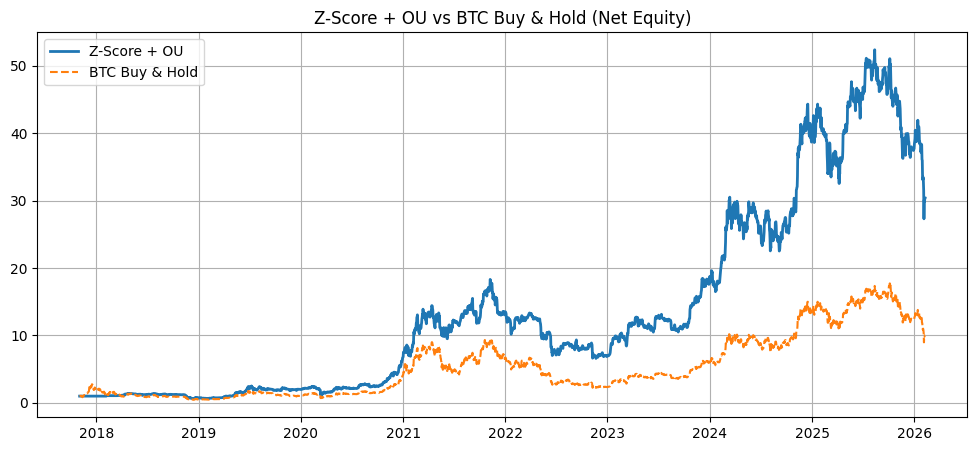

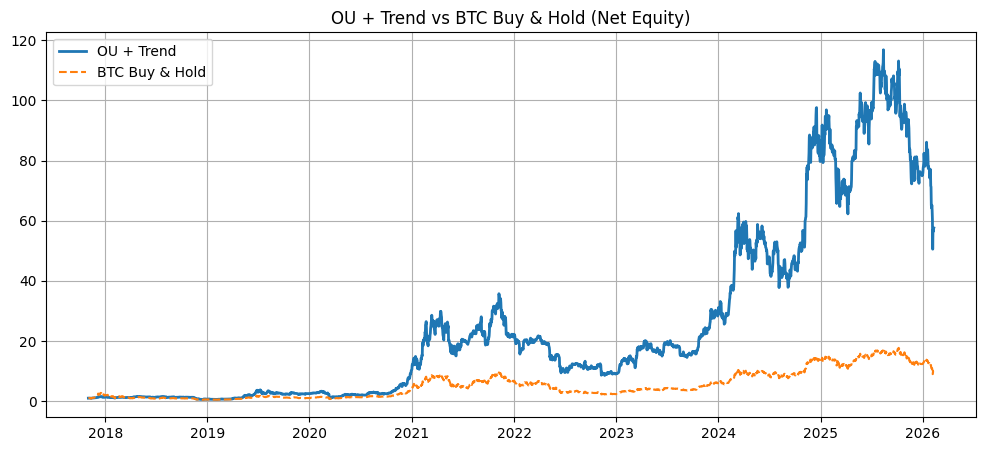

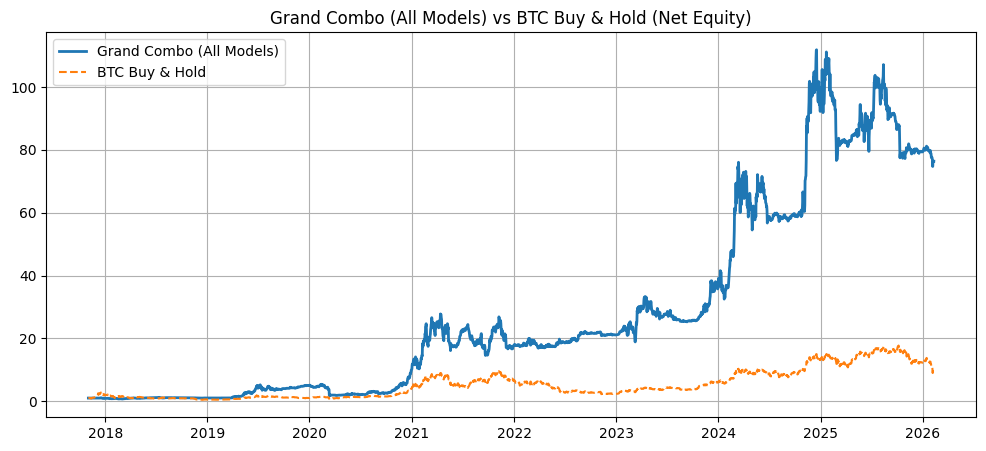

In [26]:
# ----------------------------
# CELL 7: equity plots (safe)
# ----------------------------
import matplotlib.pyplot as plt

strategy_equity = {
    "Z-Score": z_results["net_equity"],
    "OU": ou_results["net_equity"],
    "Trend": trend_results["net_equity"],
    "Mining": mining_results["net_equity"],
}

# Optional combos: only include if they exist
optional = {
    "Stochastic Tactical": "stochastic_results",
    "Z-Score + OU": "z_ou_results",
    "OU + Trend": "ou_trend_results",
    "Grand Combo (All Models)": "all_models_results",
}
for name, var in optional.items():
    if var in globals() and isinstance(globals()[var], dict) and "net_equity" in globals()[var]:
        strategy_equity[name] = globals()[var]["net_equity"]

for name, eq in strategy_equity.items():
    plt.figure(figsize=(12, 5))
    plt.plot(eq, label=name, linewidth=2.0)
    plt.plot(buy_hold_results["net_equity"], label="BTC Buy & Hold", linestyle="--")
    plt.title(f"{name} vs BTC Buy & Hold (Net Equity)")
    plt.legend()
    plt.grid(True)
    plt.show()

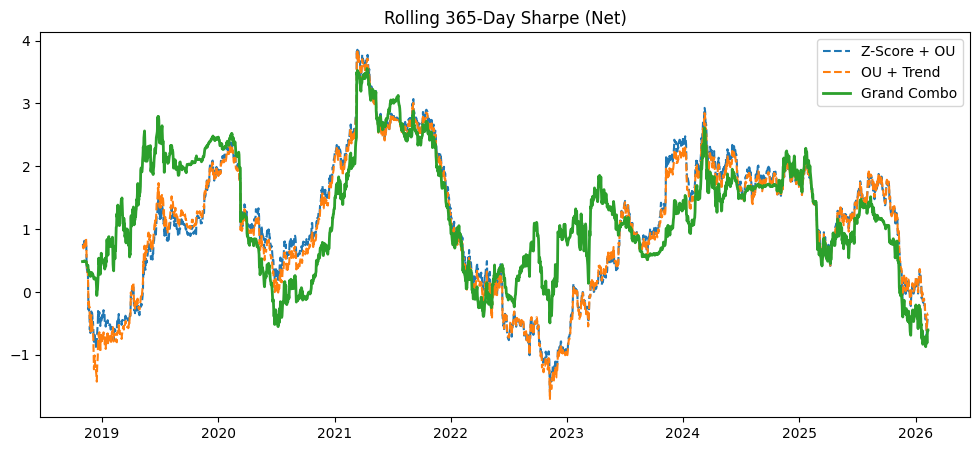

In [27]:
# ----------------------------
# CELL 8: rolling sharpe plot (FIXED extra plt.show)
# ----------------------------
plt.figure(figsize=(12, 5))
plt.plot(rolling_sharpe(z_ou_results["net_returns"], window=365), label="Z-Score + OU", linestyle="--")
plt.plot(rolling_sharpe(ou_trend_results["net_returns"], window=365), label="OU + Trend", linestyle="--")
plt.plot(rolling_sharpe(all_models_results["net_returns"], window=365), label="Grand Combo", linewidth=2.0)
plt.title("Rolling 365-Day Sharpe (Net)")
plt.legend()
plt.show()

In [28]:
# ----------------------------
# Define drawdown function
# ----------------------------
def drawdown(equity: pd.Series) -> pd.Series:
    """
    Computes drawdown series from equity curve.
    Drawdown = equity / running_max - 1
    """
    equity = equity.astype(float)
    running_max = equity.cummax()
    dd = equity / running_max - 1.0
    return dd

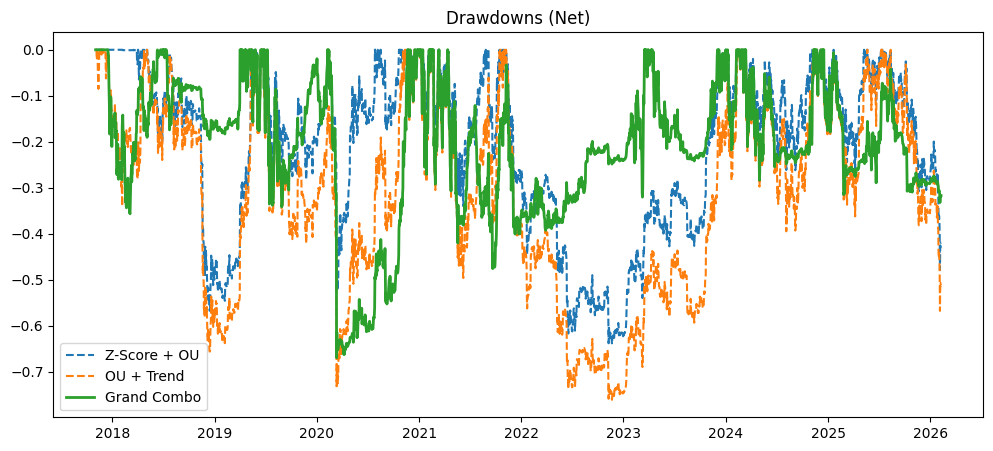

In [29]:
# ----------------------------
# CELL 9: drawdowns (FIXED extra plt.show)
# NOTE: requires drawdown() to be defined/imported in your notebook.
# ----------------------------
plt.figure(figsize=(12, 5))
plt.plot(drawdown(z_ou_results["net_equity"]), label="Z-Score + OU", linestyle="--")
plt.plot(drawdown(ou_trend_results["net_equity"]), label="OU + Trend", linestyle="--")
plt.plot(drawdown(all_models_results["net_equity"]), label="Grand Combo", linewidth=2.0)
plt.title("Drawdowns (Net)")
plt.legend()
plt.show()

In [30]:
# ----------------------------
# Define annual_turnover
# ----------------------------
import config as cfg

def annual_turnover(pos: pd.Series, days_per_year: int = cfg.DAYS_PER_YEAR) -> float:
    """
    Annualized turnover:
        mean(|Δposition|) * days_per_year
    """
    pos = pos.fillna(0.0)
    turn = pos.diff().abs().fillna(0.0)
    return float(turn.mean() * days_per_year)

In [31]:
# ----------------------------
# CELL 10: turnover prints (FIXED duplicate mining line)
# NOTE: requires annual_turnover() to be defined/imported.
# ----------------------------
print("Annual Turnover Buy&Hold:", annual_turnover(buy_hold_pos))
print("Annual Turnover Z:", annual_turnover(z_pos))
print("Annual Turnover OU:", annual_turnover(ou_pos))
print("Annual Turnover Trend:", annual_turnover(trend_pos))
print("Annual Turnover Mining:", annual_turnover(mining_pos))
print("Annual Turnover Stochastic Tactical:", annual_turnover(stochastic_pos))
print("Annual Turnover Z+OU:", annual_turnover(z_ou_pos))
print("Annual Turnover OU+Trend:", annual_turnover(ou_trend_pos))
print("Annual Turnover Grand Combo:", annual_turnover(all_models_pos))

Annual Turnover Buy&Hold: 0.0
Annual Turnover Z: 7.6167605167273935
Annual Turnover OU: 0.1209009605829745
Annual Turnover Trend: 1.9706856575024847
Annual Turnover Mining: 4.110632659821133
Annual Turnover Stochastic Tactical: 16.563431599867506
Annual Turnover Z+OU: 9.986419344153692
Annual Turnover OU+Trend: 13.118963232858563
Annual Turnover Grand Combo: 17.43391851606492


In [32]:
# ----------------------------
# CELL 11: alpha diagnostics (as-is, but clean cell)
# ----------------------------
def alpha_diagnostics(strategy_returns: pd.Series, benchmark_returns: pd.Series) -> dict:
    aligned = pd.concat([strategy_returns, benchmark_returns], axis=1).dropna()
    aligned.columns = ["strategy", "benchmark"]

    excess = aligned["strategy"] - aligned["benchmark"]
    alpha_ann = float(excess.mean() * 365)
    info_ratio = float((excess.mean() / excess.std(ddof=1)) * np.sqrt(365)) if excess.std(ddof=1) > 0 else np.nan

    return {
        "Alpha_Annualized": alpha_ann,
        "InformationRatio": info_ratio,
    }

def get_ret(results_dict):
    return results_dict.get("net_ret", results_dict.get("net_returns"))

combo_alpha = pd.DataFrame({
    "Z-Score + OU": alpha_diagnostics(get_ret(z_ou_results), get_ret(buy_hold_results)),
    "OU + Trend": alpha_diagnostics(get_ret(ou_trend_results), get_ret(buy_hold_results)),
    "Grand Combo (All Models)": alpha_diagnostics(get_ret(all_models_results), get_ret(buy_hold_results)),
}).T

combo_alpha

,Alpha_Annualized,InformationRatio
Z-Score + OU,0.068261,0.220275
OU + Trend,0.300835,1.020586
Grand Combo (All Models),0.221206,0.380797


In [33]:
# ----------------------------
# FINAL CELL A: Trend + Mining (0.5 / 0.5) position + backtest
# Requires: trend_pos, mining_pos, run_backtest_from_position, sharpe (or compute here), cfg
# ----------------------------
import config as cfg
import numpy as np
import pandas as pd

# 0.5 / 0.5 linear combo
trend_mining_pos = (0.5 * trend_pos + 0.5 * mining_pos).clip(-cfg.LEVERAGE_CAP, cfg.LEVERAGE_CAP)
trend_mining_pos = trend_mining_pos.shift(1).fillna(0.0)

price_btc = df[cfg.PRICE_COLUMN_BTC].astype(float)

trend_mining_results = run_backtest_from_position(
    price=price_btc,
    pos=trend_mining_pos,
    fee_bps=cfg.FEE_BPS,
    slippage_bps=cfg.SLIPPAGE_BPS,
)

trend_mining_sharpe = np.sqrt(cfg.DAYS_PER_YEAR) * trend_mining_results["net_ret"].mean() / trend_mining_results["net_ret"].std()

print("Sharpe (Trend + Mining 0.5/0.5) net:", float(trend_mining_sharpe))
trend_mining_results["net_equity"].tail()

Sharpe (Trend + Mining 0.5/0.5) net: 0.9673829563842569


Date
2026-02-05    17.864053
2026-02-06    18.507143
2026-02-07    18.461886
2026-02-08    18.573215
2026-02-09    18.570551
dtype: float64

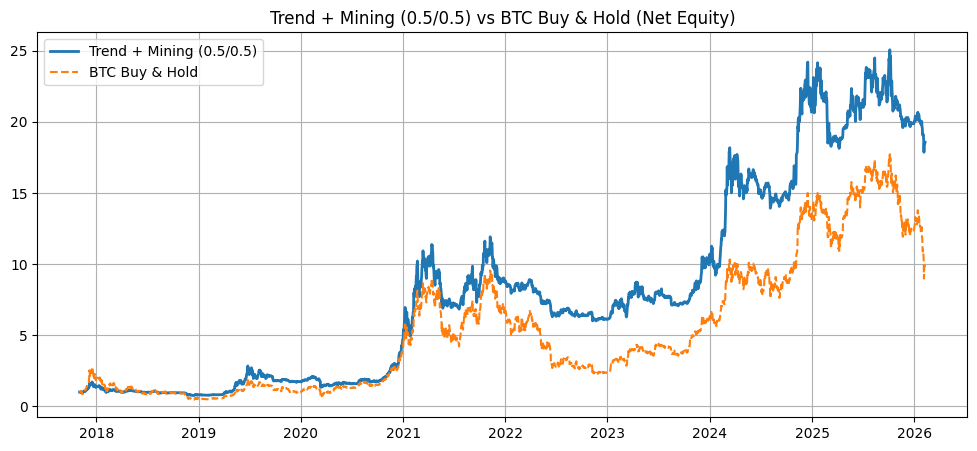

In [34]:
# ----------------------------
# FINAL CELL B: Plot equity curve (Trend+Mining) vs Buy&Hold
# Requires: buy_hold_results, trend_mining_results
# ----------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(trend_mining_results["net_equity"], label="Trend + Mining (0.5/0.5)", linewidth=2.0)
plt.plot(buy_hold_results["net_equity"], label="BTC Buy & Hold", linestyle="--")
plt.title("Trend + Mining (0.5/0.5) vs BTC Buy & Hold (Net Equity)")
plt.legend()
plt.grid(True)
plt.show()

In [35]:
# ----------------------------
# Try adding OU to Trend+Mining only if it improves Sharpe
# ----------------------------
import numpy as np

def sr(x: pd.Series) -> float:
    x = x.dropna()
    if x.std() == 0 or len(x) < 10:
        return np.nan
    return float(np.sqrt(cfg.DAYS_PER_YEAR) * x.mean() / x.std())

base_sr = sr(trend_mining_results["net_ret"])

alphas = np.linspace(0.0, 1.0, 21)

best = {
    "alpha_ou": 0.0,
    "sr": base_sr,
    "pos": trend_mining_pos,
    "results": trend_mining_results,
    "label": "Trend+Mining (0.5/0.5)"
}

ou_pos_aligned = ou_pos.reindex(price_btc.index).fillna(0.0)

for a in alphas:
    combo_pos = ((1 - a) * trend_mining_pos + a * ou_pos_aligned).clip(-cfg.LEVERAGE_CAP, cfg.LEVERAGE_CAP)
    combo_pos = combo_pos.shift(1).fillna(0.0)

    combo_results = run_backtest_from_position(
        price=price_btc,
        pos=combo_pos,
        fee_bps=cfg.FEE_BPS,
        slippage_bps=cfg.SLIPPAGE_BPS,
    )

    combo_sr = sr(combo_results["net_ret"])

    if np.isfinite(combo_sr) and combo_sr > best["sr"] + 1e-6:
        best = {
            "alpha_ou": float(a),
            "sr": float(combo_sr),
            "pos": combo_pos,
            "results": combo_results,
            "label": f"Trend+Mining+OU (best a={a:.2f})"
        }

print("Base Trend+Mining Sharpe:", base_sr)
print("Best Sharpe after adding OU:", best["sr"])
print("Selected model:", best["label"])

best_combo_pos = best["pos"]
best_combo_results = best["results"]

Base Trend+Mining Sharpe: 0.9673829563842569
Best Sharpe after adding OU: 0.9673829563842569
Selected model: Trend+Mining (0.5/0.5)


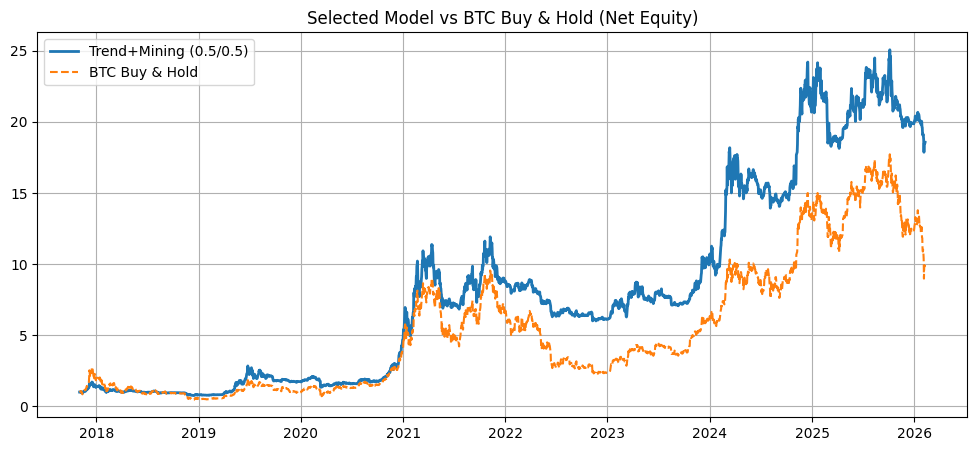

In [36]:
# ----------------------------
# Equity curve: selected model vs Buy&Hold
# ----------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(best_combo_results["net_equity"], label=best["label"], linewidth=2.0)
plt.plot(buy_hold_results["net_equity"], label="BTC Buy & Hold", linestyle="--")
plt.title("Selected Model vs BTC Buy & Hold (Net Equity)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# ----------------------------
# FINAL CELL C: Apply selected combination model to IBIT and build equity curve
# ----------------------------
import pandas as pd

ibit_path = "../Data/IBIT_Data.csv"
ibit = pd.read_csv(ibit_path)

# Parse IBIT date/price robustly
ibit['Date'] = pd.to_datetime(ibit['Date'], errors='coerce')
if 'Price' in ibit.columns:
    ibit_price = (
        ibit['Price']
        .astype(str)
        .str.replace(',', '', regex=False)
        .str.replace('$', '', regex=False)
        .astype(float)
    )
elif 'IBIT_price' in ibit.columns:
    ibit_price = ibit['IBIT_price'].astype(float)
else:
    raise ValueError("IBIT CSV must contain either 'Price' or 'IBIT_price' column")

ibit_df = pd.DataFrame({'IBIT_close': ibit_price.values}, index=ibit['Date']).sort_index()
ibit_df = ibit_df[~ibit_df.index.duplicated(keep='last')]
ibit_df = ibit_df.dropna(subset=['IBIT_close'])

# Align selected combo position (from BTC model) onto IBIT dates
ibit_pos = best_combo_pos.reindex(ibit_df.index).ffill().fillna(0.0)
ibit_pos = ibit_pos.clip(-cfg.LEVERAGE_CAP, cfg.LEVERAGE_CAP)

ibit_combo_results = run_backtest_from_position(
    price=ibit_df['IBIT_close'],
    pos=ibit_pos,
    fee_bps=cfg.FEE_BPS,
    slippage_bps=cfg.SLIPPAGE_BPS,
)

ibit_buy_hold_pos = pd.Series(1.0, index=ibit_df.index, dtype=float)
ibit_buy_hold_results = run_backtest_from_position(
    price=ibit_df['IBIT_close'],
    pos=ibit_buy_hold_pos,
    fee_bps=cfg.FEE_BPS,
    slippage_bps=cfg.SLIPPAGE_BPS,
)

print('IBIT range:', ibit_df.index.min(), '->', ibit_df.index.max())
print('IBIT combo Sharpe:', sr(ibit_combo_results['net_ret']))
print('IBIT buy&hold Sharpe:', sr(ibit_buy_hold_results['net_ret']))


In [ ]:
# ----------------------------
# FINAL CELL D: Equity curve on IBIT (combination model strategy)
# ----------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(ibit_combo_results['net_equity'], label=f"IBIT {best['label']}", linewidth=2.0)
plt.plot(ibit_buy_hold_results['net_equity'], label='IBIT Buy & Hold', linestyle='--')
plt.title('IBIT Equity Curve: Combination Model vs Buy & Hold (Net Equity)')
plt.legend()
plt.grid(True)
plt.show()
